#  Aging Analysis
## _Author(s): Wai Yuen (Wylliam) Cheng_

In [185]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from scipy import stats
import os
from sklearn import preprocessing

In [114]:
## cluster ellipse: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

def plot_ellipse(ax, data, color):
    mean = np.mean(data, axis=0) 
    cov = np.cov(data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # Sort eigenvalues and eigenvectors
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    # Calculate angle in degrees
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    # Width and height of the ellipse (scaled by sqrt of eigenvalues)
    width, height = 2 * np.sqrt(eigenvalues)
    # Draw the ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', lw=2)
    ax.add_patch(ellipse)

## Data Ingestion

In [115]:
df_human_gene = pd.read_csv("../BE700_human_expression.(1) (1) (1).csv", sep=",", index_col=0)
df_human_pheno = pd.read_csv("../human_pheno_postprocessed.csv", sep=",", index_col=0)

## Removing columns with missing data for all samples under the 'DM' class
df_human_pheno = df_human_pheno.drop(columns=["2 hour glucose (ogtt):ch1", "fasting glucose (ogtt):ch1"])
df_human_pheno

,age (years):ch1,body mass index (kg/m2):ch1,family history:ch1,fasting glucose (iv0gavg):ch1,fasting insulin (iv0inavg):ch1,gender:ch1,hemoglobin a1c:ch1,si:ch1,waist hip ratio:ch1,diabete_2
GSM624925,39,20,Family history negative,90,2.70,female,5.6,11.91,1.364,0
GSM624926,23,23,Family history negative,87,4.40,male,5.0,8.31,0.792,0
GSM624927,42,21,Family history negative,79,6.10,female,4.6,1.59,0.824,0
GSM624928,40,27,Family history negative,91,5.60,male,5.1,8.38,0.981,0
GSM624929,57,22,Family history negative,94,5.00,female,5.5,4.06,NaN,0
GSM624930,23,25,Family history negative,91,8.00,female,4.3,6.53,0.833,0
GSM624931,46,26,Family history negative,88,4.40,female,5.4,10.39,0.845,0
GSM624932,28,24,Family history negative,83,1.70,male,4.7,14.28,0.865,0
GSM624933,38,25,Family history negative,88,4.60,male,5.1,10.29,0.902,0
GSM624934,50,33,Family history negative,109,15.90,male,5.4,1.70,1.018,0


In [116]:
## Convert SI to log(SI)
df_human_pheno['si:ch1'] = np.log(df_human_pheno['si:ch1'])
df_human_pheno

,age (years):ch1,body mass index (kg/m2):ch1,family history:ch1,fasting glucose (iv0gavg):ch1,fasting insulin (iv0inavg):ch1,gender:ch1,hemoglobin a1c:ch1,si:ch1,waist hip ratio:ch1,diabete_2
GSM624925,39,20,Family history negative,90,2.70,female,5.6,2.477378,1.364,0
GSM624926,23,23,Family history negative,87,4.40,male,5.0,2.117460,0.792,0
GSM624927,42,21,Family history negative,79,6.10,female,4.6,0.463734,0.824,0
GSM624928,40,27,Family history negative,91,5.60,male,5.1,2.125848,0.981,0
GSM624929,57,22,Family history negative,94,5.00,female,5.5,1.401183,NaN,0
GSM624930,23,25,Family history negative,91,8.00,female,4.3,1.876407,0.833,0
GSM624931,46,26,Family history negative,88,4.40,female,5.4,2.340844,0.845,0
GSM624932,28,24,Family history negative,83,1.70,male,4.7,2.658860,0.865,0
GSM624933,38,25,Family history negative,88,4.60,male,5.1,2.331173,0.902,0
GSM624934,50,33,Family history negative,109,15.90,male,5.4,0.530628,1.018,0


### Data Imputation

In [117]:
from sklearn.impute import KNNImputer
nan = np.nan
X = np.array(df_human_pheno['si:ch1']).reshape(-1, 1)
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_human_pheno['si:ch1'] = imputer.fit_transform(X)
X = np.array(df_human_pheno['waist hip ratio:ch1']).reshape(-1, 1)
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_human_pheno['waist hip ratio:ch1'] = imputer.fit_transform(X)

df_human_pheno

,age (years):ch1,body mass index (kg/m2):ch1,family history:ch1,fasting glucose (iv0gavg):ch1,fasting insulin (iv0inavg):ch1,gender:ch1,hemoglobin a1c:ch1,si:ch1,waist hip ratio:ch1,diabete_2
GSM624925,39,20,Family history negative,90,2.70,female,5.6,2.477378,1.364000,0
GSM624926,23,23,Family history negative,87,4.40,male,5.0,2.117460,0.792000,0
GSM624927,42,21,Family history negative,79,6.10,female,4.6,0.463734,0.824000,0
GSM624928,40,27,Family history negative,91,5.60,male,5.1,2.125848,0.981000,0
GSM624929,57,22,Family history negative,94,5.00,female,5.5,1.401183,0.889735,0
GSM624930,23,25,Family history negative,91,8.00,female,4.3,1.876407,0.833000,0
GSM624931,46,26,Family history negative,88,4.40,female,5.4,2.340844,0.845000,0
GSM624932,28,24,Family history negative,83,1.70,male,4.7,2.658860,0.865000,0
GSM624933,38,25,Family history negative,88,4.60,male,5.1,2.331173,0.902000,0
GSM624934,50,33,Family history negative,109,15.90,male,5.4,0.530628,1.018000,0


### T-Test (Using 40 yo young threshold)

In [118]:
df_classified_gene = df_human_gene.T.assign(age=list(df_human_pheno.apply(lambda x: 1 if x["age (years):ch1"] >= 40 else 0, axis=1)))
df_classified_gene

,NaN,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,...,ZXDA,ZXDB,ZXDB///ZXDA,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,age
GSM624925,8.471675,6.826548,6.841722,9.203944,12.070644,10.291976,8.722733,9.391888,7.968091,9.700786,...,10.392317,9.519565,8.161837,10.458022,6.938991,14.932713,11.483651,8.699052,10.999399,0
GSM624926,8.454916,7.133399,6.892391,7.152580,12.384987,10.652038,6.916573,10.004361,7.910493,10.268074,...,10.693748,9.744577,8.060379,10.367772,4.857981,15.712538,10.494377,8.372430,11.046991,0
GSM624927,8.556889,6.812498,7.330917,7.967381,12.021358,10.684135,9.108236,9.114783,5.733354,9.715447,...,10.723490,9.901634,8.665753,10.272492,5.436295,15.286579,11.120819,7.827184,11.193368,1
GSM624928,8.494256,7.022368,7.744834,8.668846,12.076220,10.653741,9.163661,9.479376,8.090642,9.434837,...,10.365010,9.413637,8.608526,10.294129,5.904484,15.574047,11.202640,9.100925,11.196311,1
GSM624929,8.532161,8.620220,6.035624,9.281442,12.111531,10.922733,9.048243,9.872059,5.201634,9.613053,...,10.824243,9.881409,8.162768,10.547895,8.192786,14.932519,11.090102,8.462298,11.561014,1
GSM624930,8.670656,6.831624,7.029011,8.735617,11.928383,10.582612,7.823916,9.298521,9.378512,9.301725,...,10.658658,8.269888,9.074226,10.772724,6.605850,15.298123,10.709364,7.874059,11.333701,0
GSM624931,8.480992,4.364572,5.675251,8.116074,12.246184,10.702692,9.738817,8.601028,9.316282,9.561479,...,10.542935,8.478639,8.197722,10.394143,4.887525,15.049772,10.530310,9.045760,11.441655,1
GSM624932,8.572890,9.176423,6.675251,8.624294,11.657184,10.752381,8.885125,8.127221,6.159871,8.429616,...,10.839912,8.280631,8.371494,10.488997,6.632268,15.205690,10.714498,9.044121,11.491251,0
GSM624933,8.705287,7.197708,6.898450,9.202751,12.274542,10.785289,9.047942,9.084543,8.151778,9.880808,...,10.519931,9.127255,8.528291,10.128301,6.112700,15.178727,11.474636,8.232661,10.975295,0
GSM624934,8.578561,4.877744,7.646019,8.558300,12.071838,10.586465,9.113890,9.268893,8.586465,9.316282,...,10.747773,9.774830,8.462205,10.467235,7.073606,15.420862,10.546667,8.342519,11.608255,1


In [119]:
grouped = df_classified_gene.groupby('age')

group_0 = grouped.get_group(0).drop('age', axis=1)
group_1 = grouped.get_group(1).drop('age', axis=1)

results = {}
for gene in group_0.columns:
    t_stat, p_val = stats.ttest_ind(group_0[gene], group_1[gene], equal_var=False)  # Welch's t-test
    results[gene] = {'t_stat': t_stat, 'p_val': p_val}

results_df_classified_gene = pd.DataFrame(results).T
results_df_classified_gene.sort_values('p_val', inplace=True)
results_df_classified_gene.to_csv("welch_t_test_results_to_age_40yo.csv")

### Extract top 100/1000 genes

In [120]:
top_100_classified_gene = list(pd.read_csv("welch_t_test_results_to_age_40yo.csv", index_col=0).head(100).index)
top_1000_classified_gene = list(pd.read_csv("welch_t_test_results_to_age_40yo.csv", index_col=0).head(1000).index)

### PCA (From Raw Data) (old/young Title)

In [121]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [122]:
scaling = StandardScaler()

df_pca_human_gene = scaling.fit_transform(np.array(df_human_gene).T)
pd.DataFrame(df_pca_human_gene)

pca = PCA(n_components=2)
gene_pca = pca.fit_transform(df_pca_human_gene)

print(gene_pca)

[[  14.81947516  -28.97189912]
 [   8.8185703     3.08559357]
 [  19.56220976   26.71882897]
 [  18.26234746   -7.23101924]
 [  17.44033208  -12.86895088]
 [ -14.33617936   42.48602094]
 [ -22.46252396   37.25556654]
 [ -29.05346829   32.20309273]
 [  52.83617856  -13.13075384]
 [   0.92660035   32.73405246]
 [  71.7619211   -25.63237806]
 [ -33.11756597   39.15881577]
 [  22.14249915    7.64363119]
 [-170.58433732  -67.68403748]
 [ -47.7116448    56.85704695]
 [ -79.55793505   72.64894393]
 [  28.12551977    5.08710506]
 [  27.64087413    9.84727834]
 [  23.29859742   10.42166913]
 [  26.27481503  -14.61871081]
 [ -16.46759592  -14.42404782]
 [-139.5968742   -62.56477206]
 [  25.81251588    4.96335422]
 [  52.46853769  -20.929106  ]
 [  -5.94686184  -30.74812075]
 [  19.48868688   24.21086323]
 [ -45.26338705   70.86287742]
 [ -19.76179096   26.50912985]
 [   2.1668182   -11.17100183]
 [  32.18702599   -5.62337384]
 [ -10.57154708  -37.15562908]
 [  10.65455369  -26.5080499 ]
 [  19.5

Text(0, 0.5, 'pc2')

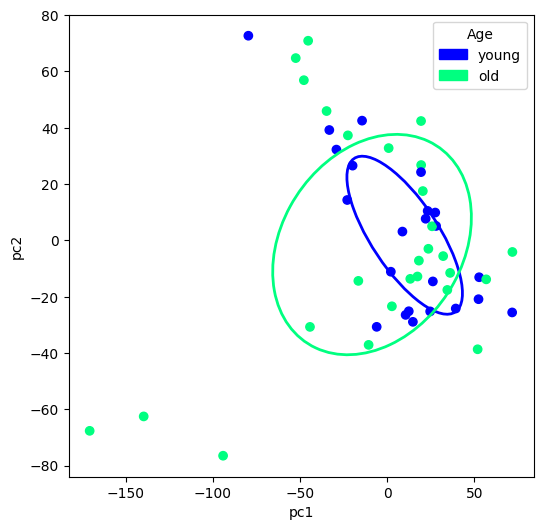

In [123]:
plt.figure(figsize=(6,6))
scatter = plt.scatter(gene_pca[:,0],gene_pca[:,1],c=df_classified_gene['age'],cmap='winter')
unique_classes = df_classified_gene['age'].unique()
colors = [scatter.cmap(scatter.norm(value)) for value in unique_classes]
legend_patches = [
    mpatches.Patch(color=colors[i], label="old" if unique_classes[i] == 1 else "young")
    for i in range(len(unique_classes))
]
ax = plt.gca()
for i, cls in enumerate(unique_classes):
    cluster_data = gene_pca[df_classified_gene['age'] == cls]
    plot_ellipse(ax, cluster_data, colors[i])

plt.legend(handles=legend_patches, title="Age", loc="best")
plt.xlabel('pc1')
plt.ylabel('pc2')

In [124]:
scaling = StandardScaler()

df_pca_human_gene = scaling.fit_transform(np.array(df_human_gene).T)
pd.DataFrame(df_pca_human_gene)

pca = PCA(n_components=3)
gene_pca = pca.fit_transform(df_pca_human_gene)

gene_pca_df = pd.DataFrame(gene_pca, columns=['PC1', 'PC2', 'PC3'])

print(gene_pca)

[[  14.81955231  -28.97823236  -39.89066549]
 [   8.81877916    3.08277829  -16.24192485]
 [  19.56210024   26.73607295   -2.08700282]
 [  18.26239631   -7.2246581   -31.54322567]
 [  17.44029668  -12.86039046  -22.01296506]
 [ -14.33580031   42.47327893   10.89980392]
 [ -22.46254744   37.25603157  -13.85053155]
 [ -29.05407488   32.23325459  -14.70580713]
 [  52.83626247  -13.13061929    5.7211941 ]
 [   0.9265854    32.73097539   -3.90394741]
 [  71.76232705  -25.6719312    35.52836263]
 [ -33.11765909   39.16385405  -25.55199448]
 [  22.14259633    7.65503912  -10.7719536 ]
 [-170.58429136  -67.68334252   20.79901126]
 [ -47.7115893    56.86078198   -5.77786111]
 [ -79.55793349   72.62887942   27.50518397]
 [  28.12536264    5.09217681   -6.28826706]
 [  27.64087846    9.84661945    1.15448169]
 [  23.29854237   10.42325903    5.98158191]
 [  26.27455522  -14.5179995   -13.76600678]
 [ -16.46760133  -14.41927745  -49.52081419]
 [-139.59709731  -62.55797344    2.05107974]
 [  25.812

/var/folders/j9/4hvlltj95999sl1bmvdvgv7c0000gn/T/ipykernel_43380/3784992916.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


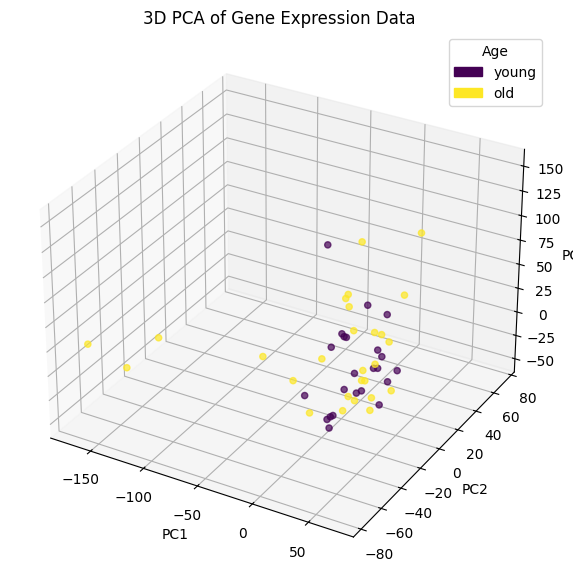

In [125]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(gene_pca_df['PC1'], gene_pca_df['PC2'], gene_pca_df['PC3'], c=df_classified_gene['age'], alpha=0.7)
unique_classes = df_classified_gene['age'].unique()
colors = [scatter.cmap(scatter.norm(value)) for value in unique_classes]
legend_patches = [
    mpatches.Patch(color=colors[i], label="old" if unique_classes[i] == 1 else "young")
    for i in range(len(unique_classes))
]

ax.legend(handles=legend_patches, title="Age", loc="best")
# Add labels and titles
ax.set_title('3D PCA of Gene Expression Data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.show()

### PCA (top 100 genes)

In [126]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [127]:
scaling = StandardScaler()

df_pca_human_gene = scaling.fit_transform(df_human_gene.loc[top_100_classified_gene].T)
pd.DataFrame(df_pca_human_gene)

pca = PCA(n_components=2)
gene_pca = pca.fit_transform(df_pca_human_gene)

print(gene_pca)

[[  4.19304097   1.79178351]
 [  8.49371589   2.4552269 ]
 [ -0.60814548  -1.42524633]
 [ -0.93381262  -2.53051823]
 [ -2.65199159  -1.73606591]
 [  4.01448739   2.3051773 ]
 [ -5.20604597   0.22167849]
 [  0.45354013   3.26976614]
 [  5.83320164  -2.15446075]
 [ -4.4003757   -2.29158862]
 [  6.0552485   -1.92339176]
 [ -0.39145695   2.64692884]
 [  5.88348679  -0.51777767]
 [-11.13282084   2.05403204]
 [ -4.95136602   0.44486739]
 [ -2.88121815   5.77540758]
 [  5.36131795   0.87889334]
 [  5.495689     1.37134946]
 [  5.55478268   0.71068571]
 [  5.93338233   0.41790245]
 [ -2.38452258  -0.32759453]
 [-11.94901077   4.89030977]
 [  2.29803916  -1.02149383]
 [  8.27788588  -1.51283246]
 [  4.51960735   2.71384837]
 [  5.93904153  -0.05517035]
 [ -7.73117725   0.69024174]
 [  2.19018623   3.65944295]
 [  4.36952675   1.74162109]
 [  0.01783006  -3.17089661]
 [ -3.88747015   2.07723337]
 [  4.61153736   1.14346964]
 [ -0.0769301   -0.85703746]
 [ -1.64752853  -3.40763693]
 [  2.30768548

Text(0, 0.5, 'pc2')

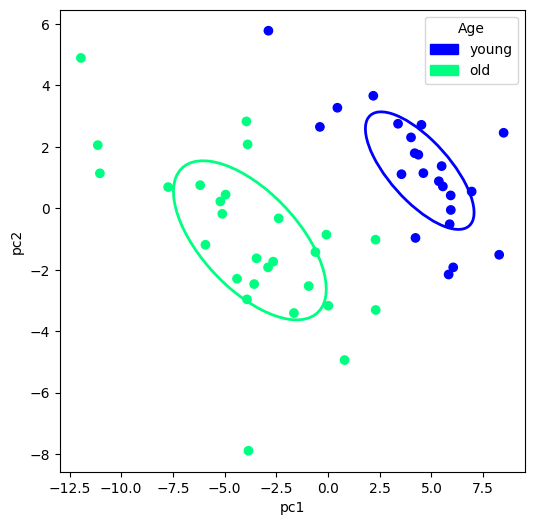

In [128]:
plt.figure(figsize=(6,6))
scatter = plt.scatter(gene_pca[:,0],gene_pca[:,1],c=df_classified_gene['age'],cmap='winter')
unique_classes = df_classified_gene['age'].unique()
colors = [scatter.cmap(scatter.norm(value)) for value in unique_classes]
legend_patches = [
    mpatches.Patch(color=colors[i], label="old" if unique_classes[i] == 1 else "young")
    for i in range(len(unique_classes))
]
ax = plt.gca()
for i, cls in enumerate(unique_classes):
    cluster_data = gene_pca[df_classified_gene['age'] == cls]
    plot_ellipse(ax, cluster_data, colors[i])

plt.legend(handles=legend_patches, title="Age", loc="best")
plt.xlabel('pc1')
plt.ylabel('pc2')

In [129]:
scaling = StandardScaler()

df_pca_human_gene = scaling.fit_transform(df_human_gene.loc[top_100_classified_gene].T)
pd.DataFrame(df_pca_human_gene)

pca = PCA(n_components=3)
gene_pca = pca.fit_transform(df_pca_human_gene)

gene_pca_df = pd.DataFrame(gene_pca, columns=['PC1', 'PC2', 'PC3'])

print(gene_pca)

[[  4.19304097   1.79178351  -3.1474563 ]
 [  8.49371589   2.4552269    2.37550382]
 [ -0.60814548  -1.42524633   2.83987031]
 [ -0.93381262  -2.53051823   2.24303128]
 [ -2.65199159  -1.73606591  -2.73483457]
 [  4.01448739   2.3051773   -0.49406514]
 [ -5.20604597   0.22167849   2.04685236]
 [  0.45354013   3.26976614   0.79972891]
 [  5.83320164  -2.15446075  -0.17974346]
 [ -4.4003757   -2.29158862   0.3267089 ]
 [  6.0552485   -1.92339176  -1.8871524 ]
 [ -0.39145695   2.64692884   0.48216114]
 [  5.88348679  -0.51777767   0.26335159]
 [-11.13282084   2.05403204   0.37231651]
 [ -4.95136602   0.44486739   2.19144576]
 [ -2.88121815   5.77540758  -1.67131837]
 [  5.36131795   0.87889334  -0.8012192 ]
 [  5.495689     1.37134946  -1.63326287]
 [  5.55478268   0.71068571   0.98004958]
 [  5.93338233   0.41790245   0.13732567]
 [ -2.38452258  -0.32759453   0.44102324]
 [-11.94901077   4.89030977  -0.25925166]
 [  2.29803916  -1.02149383   3.4323983 ]
 [  8.27788588  -1.51283246  -0.64

/var/folders/j9/4hvlltj95999sl1bmvdvgv7c0000gn/T/ipykernel_43380/3784992916.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


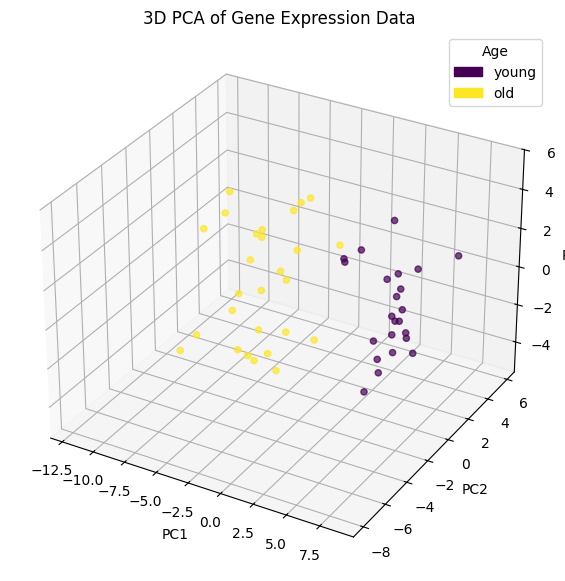

In [130]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(gene_pca_df['PC1'], gene_pca_df['PC2'], gene_pca_df['PC3'], c=df_classified_gene['age'], alpha=0.7)
unique_classes = df_classified_gene['age'].unique()
colors = [scatter.cmap(scatter.norm(value)) for value in unique_classes]
legend_patches = [
    mpatches.Patch(color=colors[i], label="old" if unique_classes[i] == 1 else "young")
    for i in range(len(unique_classes))
]

ax.legend(handles=legend_patches, title="Age", loc="best")
# Add labels and titles
ax.set_title('3D PCA of Gene Expression Data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.show()

### PCA (top 1000 genes)

In [131]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [132]:
scaling = StandardScaler()

df_pca_human_gene = scaling.fit_transform(df_human_gene.loc[top_1000_classified_gene].T)
pd.DataFrame(df_pca_human_gene)

pca = PCA(n_components=2)
gene_pca = pca.fit_transform(df_pca_human_gene)

print(gene_pca)

[[ 12.61364425  -5.9940576 ]
 [ 19.02859767  -9.89588817]
 [ -0.1903536    6.45031974]
 [  3.75547454   4.56232218]
 [ -3.03201586   8.55993295]
 [  5.4349265   -9.26476311]
 [ -9.38455747   1.47384236]
 [  0.16504596  -6.6695191 ]
 [ 17.03000005  -0.34272058]
 [ -7.36377888   6.96401163]
 [ 16.68996848   3.17120154]
 [ -2.04892015  -6.74748006]
 [ 19.98648044  -8.67239071]
 [-40.57070376 -16.88135382]
 [-15.33927532   0.35541057]
 [-11.23304366 -13.71846372]
 [ 11.76311903  -1.13467414]
 [  9.51869151   0.42207924]
 [ 10.38633938  -1.17077126]
 [ 16.46370101  -5.74053466]
 [ -4.85430394  -2.21940247]
 [-36.81784107 -11.8276113 ]
 [  6.77573543   7.52447234]
 [ 20.05839086  -1.28360943]
 [  6.2741957   -7.71311902]
 [ 12.01583802   0.24916474]
 [-20.2326326    1.45048541]
 [  2.83775551  -6.71010443]
 [ 10.17087805  -6.41940951]
 [  3.45544198   7.1736567 ]
 [ -6.59740004   3.76718806]
 [ 12.53151451  -6.61904543]
 [ -1.39822008   4.31443334]
 [  0.49586738   5.96354191]
 [  8.16549248

Text(0, 0.5, 'pc2')

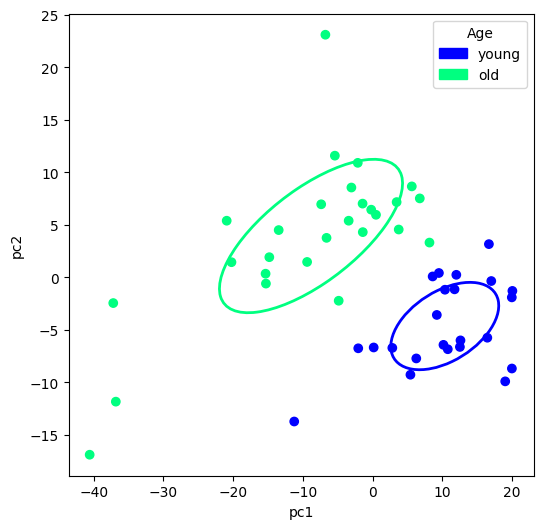

In [133]:
plt.figure(figsize=(6,6))
scatter = plt.scatter(gene_pca[:,0],gene_pca[:,1],c=df_classified_gene['age'],cmap='winter')
unique_classes = df_classified_gene['age'].unique()
colors = [scatter.cmap(scatter.norm(value)) for value in unique_classes]
legend_patches = [
    mpatches.Patch(color=colors[i], label="old" if unique_classes[i] == 1 else "young")
    for i in range(len(unique_classes))
]
ax = plt.gca()
for i, cls in enumerate(unique_classes):
    cluster_data = gene_pca[df_classified_gene['age'] == cls]
    plot_ellipse(ax, cluster_data, colors[i])


plt.legend(handles=legend_patches, title="Age", loc="best")
plt.xlabel('pc1')
plt.ylabel('pc2')

In [134]:
scaling = StandardScaler()

df_pca_human_gene = scaling.fit_transform(df_human_gene.loc[top_100_classified_gene].T)
pd.DataFrame(df_pca_human_gene)

pca = PCA(n_components=3)
gene_pca = pca.fit_transform(df_pca_human_gene)

gene_pca_df = pd.DataFrame(gene_pca, columns=['PC1', 'PC2', 'PC3'])

print(gene_pca)

[[  4.19304097   1.79178351  -3.1474563 ]
 [  8.49371589   2.4552269    2.37550382]
 [ -0.60814548  -1.42524633   2.83987031]
 [ -0.93381262  -2.53051823   2.24303128]
 [ -2.65199159  -1.73606591  -2.73483457]
 [  4.01448739   2.3051773   -0.49406514]
 [ -5.20604597   0.22167849   2.04685236]
 [  0.45354013   3.26976614   0.79972891]
 [  5.83320164  -2.15446075  -0.17974346]
 [ -4.4003757   -2.29158862   0.3267089 ]
 [  6.0552485   -1.92339176  -1.8871524 ]
 [ -0.39145695   2.64692884   0.48216114]
 [  5.88348679  -0.51777767   0.26335159]
 [-11.13282084   2.05403204   0.37231651]
 [ -4.95136602   0.44486739   2.19144576]
 [ -2.88121815   5.77540758  -1.67131837]
 [  5.36131795   0.87889334  -0.8012192 ]
 [  5.495689     1.37134946  -1.63326287]
 [  5.55478268   0.71068571   0.98004958]
 [  5.93338233   0.41790245   0.13732567]
 [ -2.38452258  -0.32759453   0.44102324]
 [-11.94901077   4.89030977  -0.25925166]
 [  2.29803916  -1.02149383   3.4323983 ]
 [  8.27788588  -1.51283246  -0.64

/var/folders/j9/4hvlltj95999sl1bmvdvgv7c0000gn/T/ipykernel_43380/3784992916.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


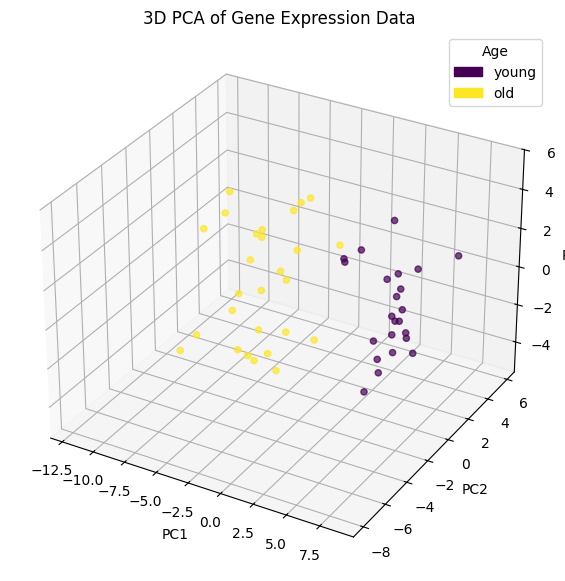

In [135]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(gene_pca_df['PC1'], gene_pca_df['PC2'], gene_pca_df['PC3'], c=df_classified_gene['age'], alpha=0.7)
unique_classes = df_classified_gene['age'].unique()
colors = [scatter.cmap(scatter.norm(value)) for value in unique_classes]
legend_patches = [
    mpatches.Patch(color=colors[i], label="old" if unique_classes[i] == 1 else "young")
    for i in range(len(unique_classes))
]

ax.legend(handles=legend_patches, title="Age", loc="best")
# Add labels and titles
ax.set_title('3D PCA of Gene Expression Data')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

fig.show()

***

In [228]:
df_human_gene = pd.read_csv("../BE700_human_expression.(1) (1) (1).csv", sep=",", index_col=0)
df_human_gene = df_human_gene.T
df_human_gene["age"] = df_human_pheno["age (years):ch1"]

df_human_gene = df_human_gene.sort_values(
    by='age', 
    key=lambda age: age <= 40
)

df_human_gene

,NaN,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,...,ZXDA,ZXDB,ZXDB///ZXDA,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,age
GSM624974,8.423746,8.292322,6.380245,7.348239,11.957426,10.229420,8.055258,8.990955,8.534497,9.316282,...,11.143511,8.728284,7.567536,10.155613,6.213347,15.357521,10.859741,8.293702,11.712559,49
GSM624957,8.724855,6.827819,7.455327,8.446559,12.470015,10.293357,8.246149,9.628628,9.092229,8.988969,...,10.807999,10.344160,8.262631,10.472774,5.778734,15.043126,10.903422,8.068241,11.400033,43
GSM624951,8.706323,5.255501,7.507002,9.142680,12.087583,10.273563,9.485664,8.756890,7.795715,9.694184,...,10.942368,8.358825,7.830576,10.701917,5.988685,15.311003,10.502457,9.782343,11.465711,51
GSM624958,8.560333,4.827819,7.454505,9.004627,11.757626,10.262447,9.410562,10.082282,7.866661,10.210184,...,10.266201,9.013405,9.316811,10.394561,5.623516,15.260519,11.333675,7.545351,11.472618,46
GSM624973,8.666402,7.673132,6.723832,7.925434,12.002147,10.548148,8.499465,9.879736,7.973267,9.868823,...,10.571847,10.140659,8.768676,11.123827,7.699052,15.007938,10.798914,7.911692,11.618784,52
GSM624959,8.564149,6.704595,8.466790,8.928683,12.151489,11.204571,9.451638,9.350497,7.769507,9.038919,...,10.485125,9.248071,8.410975,10.258658,5.392317,15.227661,10.787222,7.559951,11.070545,52
GSM624947,8.593578,7.317413,6.797013,9.555969,12.701271,10.651949,9.497641,8.802516,7.998872,8.748193,...,10.041522,9.234650,7.575986,10.033231,5.599913,15.241395,11.221498,8.695228,11.150426,44
GSM624946,8.350055,5.658211,6.238405,8.810135,11.833832,11.127285,8.513765,8.572511,8.533719,6.301953,...,10.446670,9.560739,7.012319,11.188738,6.923625,15.413420,9.719047,8.372865,11.513114,44
GSM624945,8.395320,7.245077,6.602884,9.072146,11.730040,10.869825,8.489037,9.719389,7.178914,9.495855,...,10.352264,9.691039,8.209242,10.797746,4.807355,15.007128,10.664712,7.622784,11.289257,47
GSM624961,8.438792,8.231221,6.818902,7.495640,12.038533,10.514122,7.203889,9.358871,9.654278,9.254556,...,10.057992,9.067591,8.416741,10.709667,5.095924,15.160659,11.827885,6.199672,11.066703,62


old people: 27 
young people: 23

In [235]:
gene = df_human_gene[list(top_100_classified_gene)]

scaler = preprocessing.StandardScaler()
gene = pd.DataFrame(scaler.fit_transform(gene), columns=gene.columns, index=gene.index).T
gene

,GSM624974,GSM624957,GSM624951,GSM624958,GSM624973,GSM624959,GSM624947,GSM624946,GSM624945,GSM624961,...,GSM624937,GSM624940,GSM624941,GSM624942,GSM624943,GSM624944,GSM624948,GSM624950,GSM624953,GSM624949
NPY6R,0.009954,1.213833,0.245626,-1.492733,-1.342692,-0.447311,0.837264,-0.399392,-0.197708,-1.290531,...,0.696847,0.692120,1.372482,0.742233,1.391362,0.353265,1.133646,0.597009,-0.896307,0.713708
CA4,-1.507228,-0.792688,-0.898162,0.375907,0.102437,0.653852,0.447975,-2.028158,0.552365,-0.018709,...,0.380023,-1.506641,1.539930,1.326234,0.684809,1.224216,-0.142139,1.177605,0.560195,0.089792
UNC13C,0.469662,-3.393806,1.431632,-0.287268,1.830201,0.122099,0.224833,-0.098755,0.840396,0.325993,...,-0.548241,0.744013,-1.159419,-0.214624,-0.524644,0.216882,-1.427386,0.103765,-0.052477,-1.037114
CMTM2,0.080803,1.652546,-1.574151,0.074913,-0.159923,-1.391700,-0.177297,1.136015,-1.438823,0.612781,...,0.672999,0.201782,0.692380,0.545461,1.109354,-1.412571,0.860468,0.245513,0.071959,0.533578
DEFB123,1.152707,-0.526673,-1.371255,0.740530,0.268879,-1.514653,-0.983285,-1.705361,0.877012,1.211949,...,1.928948,0.434395,0.591276,0.274362,-0.431435,0.937296,0.908574,1.677181,1.270875,0.762249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC25A12,-0.530240,0.019664,-0.167667,0.483625,-0.182220,-0.055457,0.538460,-0.569240,-0.664366,-2.104750,...,1.718920,-0.274785,0.672080,0.696846,2.506141,0.449116,-0.072826,1.329766,0.283153,1.289002
GOT1,-0.862722,1.245339,-0.482993,0.416383,-1.024762,1.151581,1.259914,-2.167907,-1.001284,-1.250705,...,0.822615,-0.960097,0.361968,0.163407,0.622553,1.715906,1.305631,1.255734,-0.066727,0.675281
LOC101927537,-0.033578,0.538593,-0.043865,0.562217,-1.064357,0.649164,0.308320,-4.180090,-0.806641,-1.491341,...,1.057448,-0.665700,-0.002922,0.088491,0.946302,0.494279,1.768877,0.717862,0.770820,-0.008769
LOC101929229,-1.216392,1.001159,0.375224,1.318072,-0.550578,0.843066,0.556037,-0.886800,-1.182107,0.043429,...,-1.021469,-2.495198,-0.055181,0.518277,0.513213,-0.160477,0.805529,0.092965,-1.675851,-0.061965


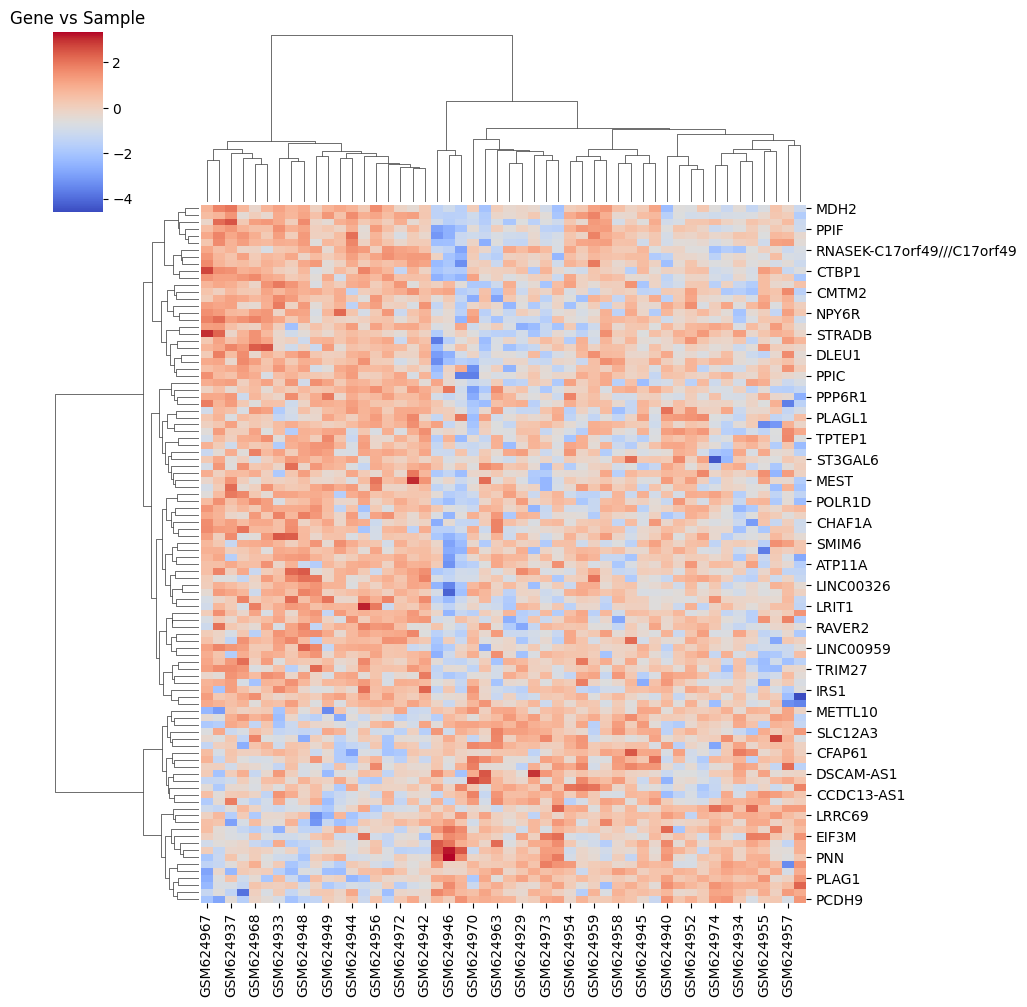

In [236]:
import seaborn as sns

sns.clustermap(gene, cmap="coolwarm", method="ward", figsize=(10, 10))

plt.title("Gene vs Sample")
plt.show()